# 基于物理公式进行特征选择的关于e_total的分组模型 

[TOC]

In [2]:
# 导库
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [1]:
# 一些参数
TEST_SIZE = 0.30
RANDOM_STATE = 42
N_SPLITS = 10
# 决策树的深度
BEST_DEPTH_0 = None
BEST_DEPTH_4 = None

In [3]:
# 导入数据
data_group0 = pd.read_csv('../../data/groups/data_training_cluster_0of5.csv')
data_group4 = pd.read_csv('../../data/groups/data_training_cluster_4of5.csv')

In [4]:
data_group0.head()

,space_group,band_gap,density,density_atomic,formation_energy_per_atom,e_total,e_ionic,e_electronic,MagpieData minimum Number,MagpieData maximum Number,...,MagpieData mean Number,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,cluster
0,173,1.4423,5.957552,25.814819,-1.615458,17.189158,8.379924,8.809235,14.0,59.0,...,39.666667,111.0,203.0,92.0,142.083333,1.13,2.55,1.42,2.089167,0
1,148,0.0000,5.698406,13.352739,-2.310143,8.953313,5.759627,3.193686,9.0,80.0,...,19.750000,57.0,139.0,82.0,76.625000,1.66,3.98,2.32,3.442500,0
2,152,4.0656,2.032981,27.083309,-0.268661,3.975662,1.825061,2.150601,6.0,55.0,...,14.666667,71.0,244.0,173.0,101.500000,0.79,3.04,2.25,2.501667,0
3,225,0.1981,6.182079,23.640230,-1.093240,58.674453,23.928634,34.745818,20.0,79.0,...,38.000000,119.0,176.0,57.0,151.750000,1.00,2.54,1.54,1.680000,0
4,139,4.3016,3.419061,15.236140,-2.856015,9.056451,6.910176,2.146275,9.0,30.0,...,14.857143,57.0,203.0,146.0,108.000000,0.82,3.98,3.16,2.744286,0


### （一）. 使用线性回归模型训练

#### 1. 进行特征缩放，归一化

In [5]:
X_0 = data_group0.drop(columns=['e_total', 'e_ionic', 'e_electronic'])
y_0 = data_group0['e_total']
X_4 = data_group4.drop(columns=['e_total', 'e_ionic', 'e_electronic'])
y_4 = data_group4['e_total']

In [6]:
scaler_0 = StandardScaler()
X_0_scaled = scaler_0.fit_transform(X_0)
scaler_4 = StandardScaler() 
X_4_scaled = scaler_4.fit_transform(X_4)

2. 训练集测试集划分

In [7]:
# 训练集测试集划分
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0_scaled, y_0, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4_scaled, y_4, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 进行模型训练

In [8]:
def model_cross_train(model, X, y):
    '''在X上训练模型model，返回交叉验证的结果：
        1. scores（neg_root_mean_squared_error）
        2. y_hat'''
    # 进行k折交叉验证
    # cross_val_predict()函数不会改变原始的模型。这个函数的主要目的是使用交叉验证来为每个输入数据点生成预测值。
    kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
    y_hat = cross_val_predict(model, X, y, cv=kfold)
    return scores, y_hat

In [9]:
# 确定好全部超参数后，使用最优的超参数在整个训练集上训练模型
def model_final_train(model, X_train, y_train):
    '''在整个训练集上训练模型model，返回训练好的模型'''
    model.fit(X_train, y_train)
    return model

def model_test(model, X_test, y_test):
    '''在测试集上测试模型model，返回测试结果：
        1. mean_squared_error
        2. mean_absolute_error
        3. y_pred'''
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae, y_pred

#### 1. LinearRegression模型 

MSE: -86.12993573041969, MAE: None


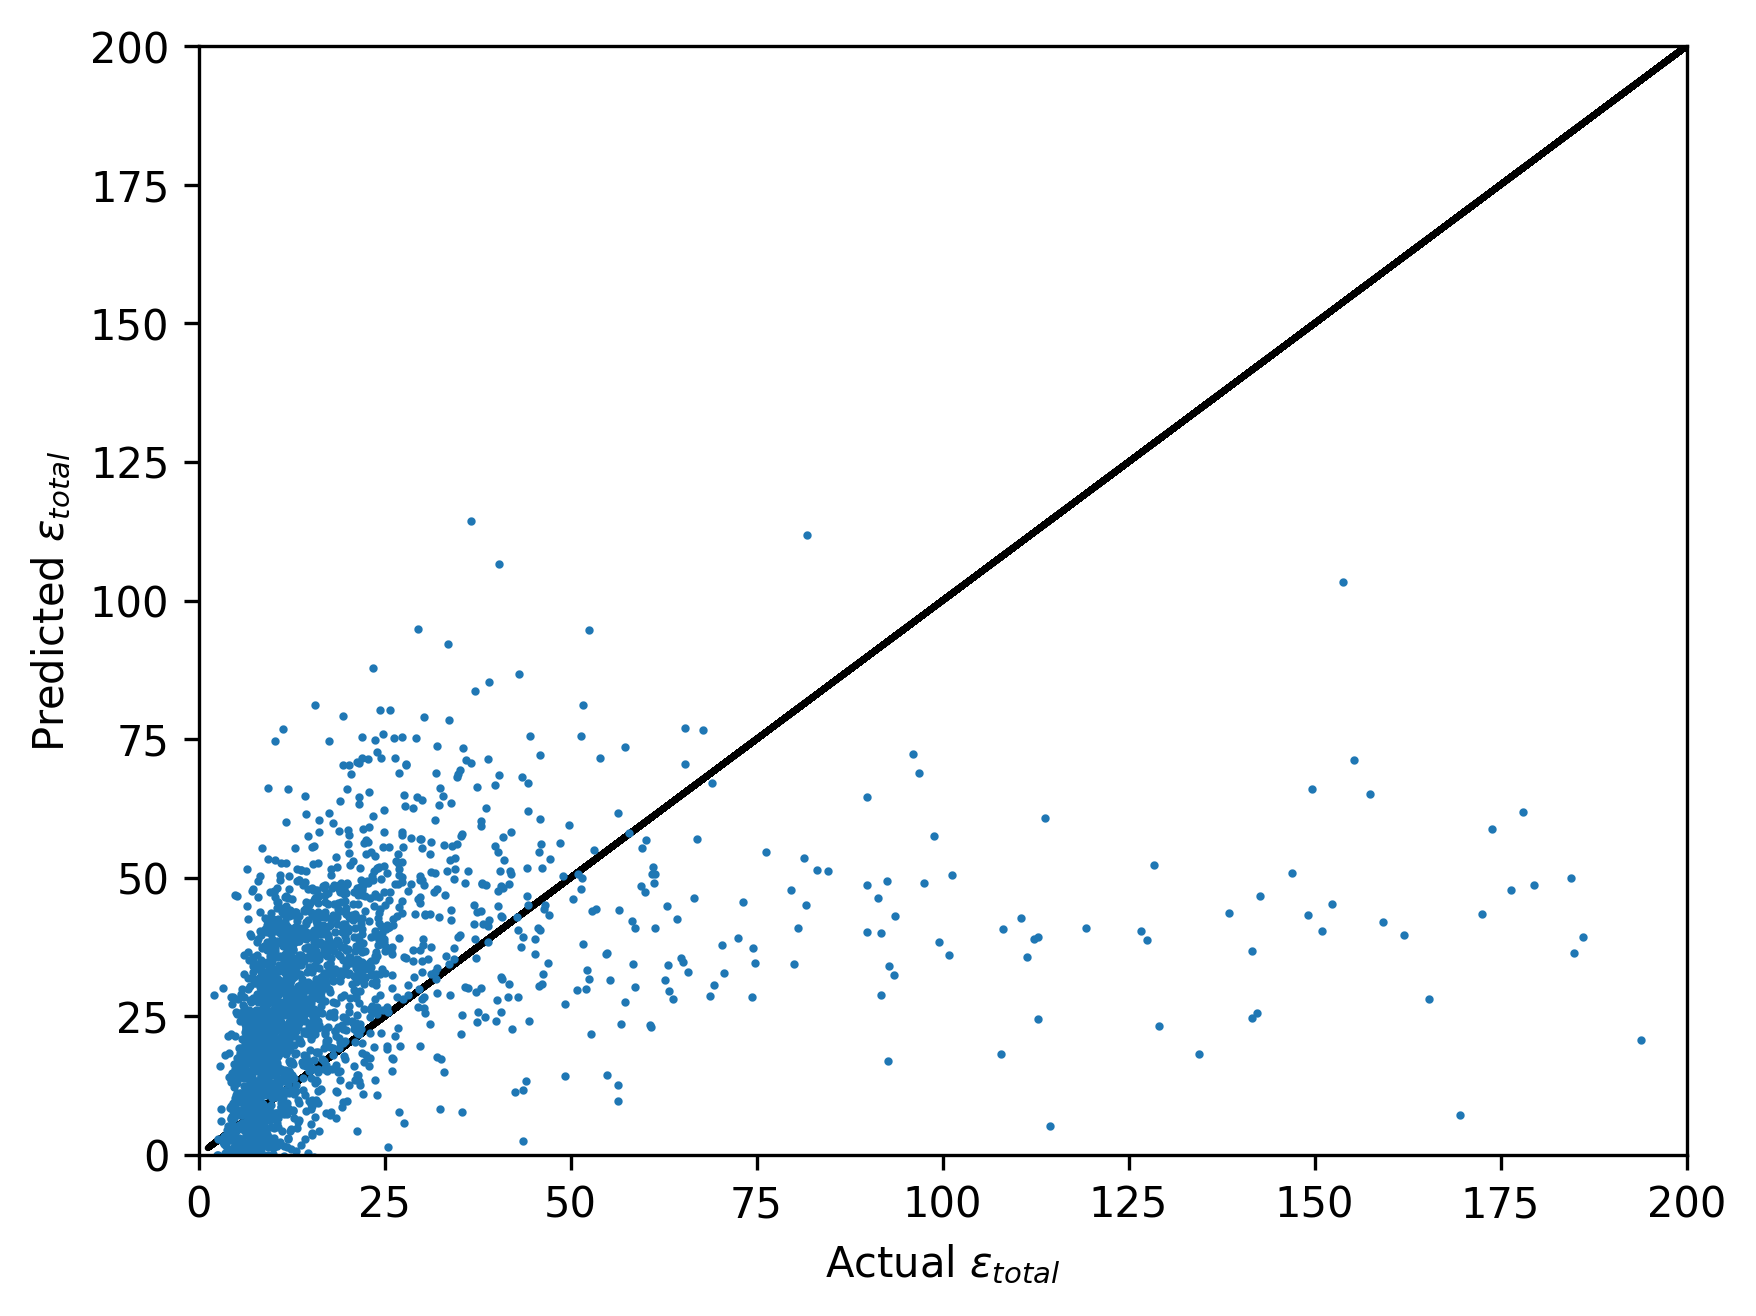

In [10]:
# 这个模型使用解析解，故不包含学习率的设置
lr = LinearRegression()
scores, y_hat = model_cross_train(lr, X_0_train, y_0_train)

def plot_cross_val_scores(mse, mae, y_hat, y_train):
    '''绘制交叉验证的结果'''
    print(f'MSE: {mse}, MAE: {mae}')

    # 绘制parity plot
    fig, ax = plt.subplots(dpi=300)
    ax.scatter(y_train, y_hat, s=1)
    ax.plot(y_train, y_train, c='k', zorder=-5)
    ax.set_xlabel('Actual $\epsilon_{total}$')
    ax.set_ylabel('Predicted $\epsilon_{total}$')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 200)
    plt.show()

plot_cross_val_scores(scores.mean(),None, y_hat, y_0_train)


MSE: -28.556694766373106, MAE: None


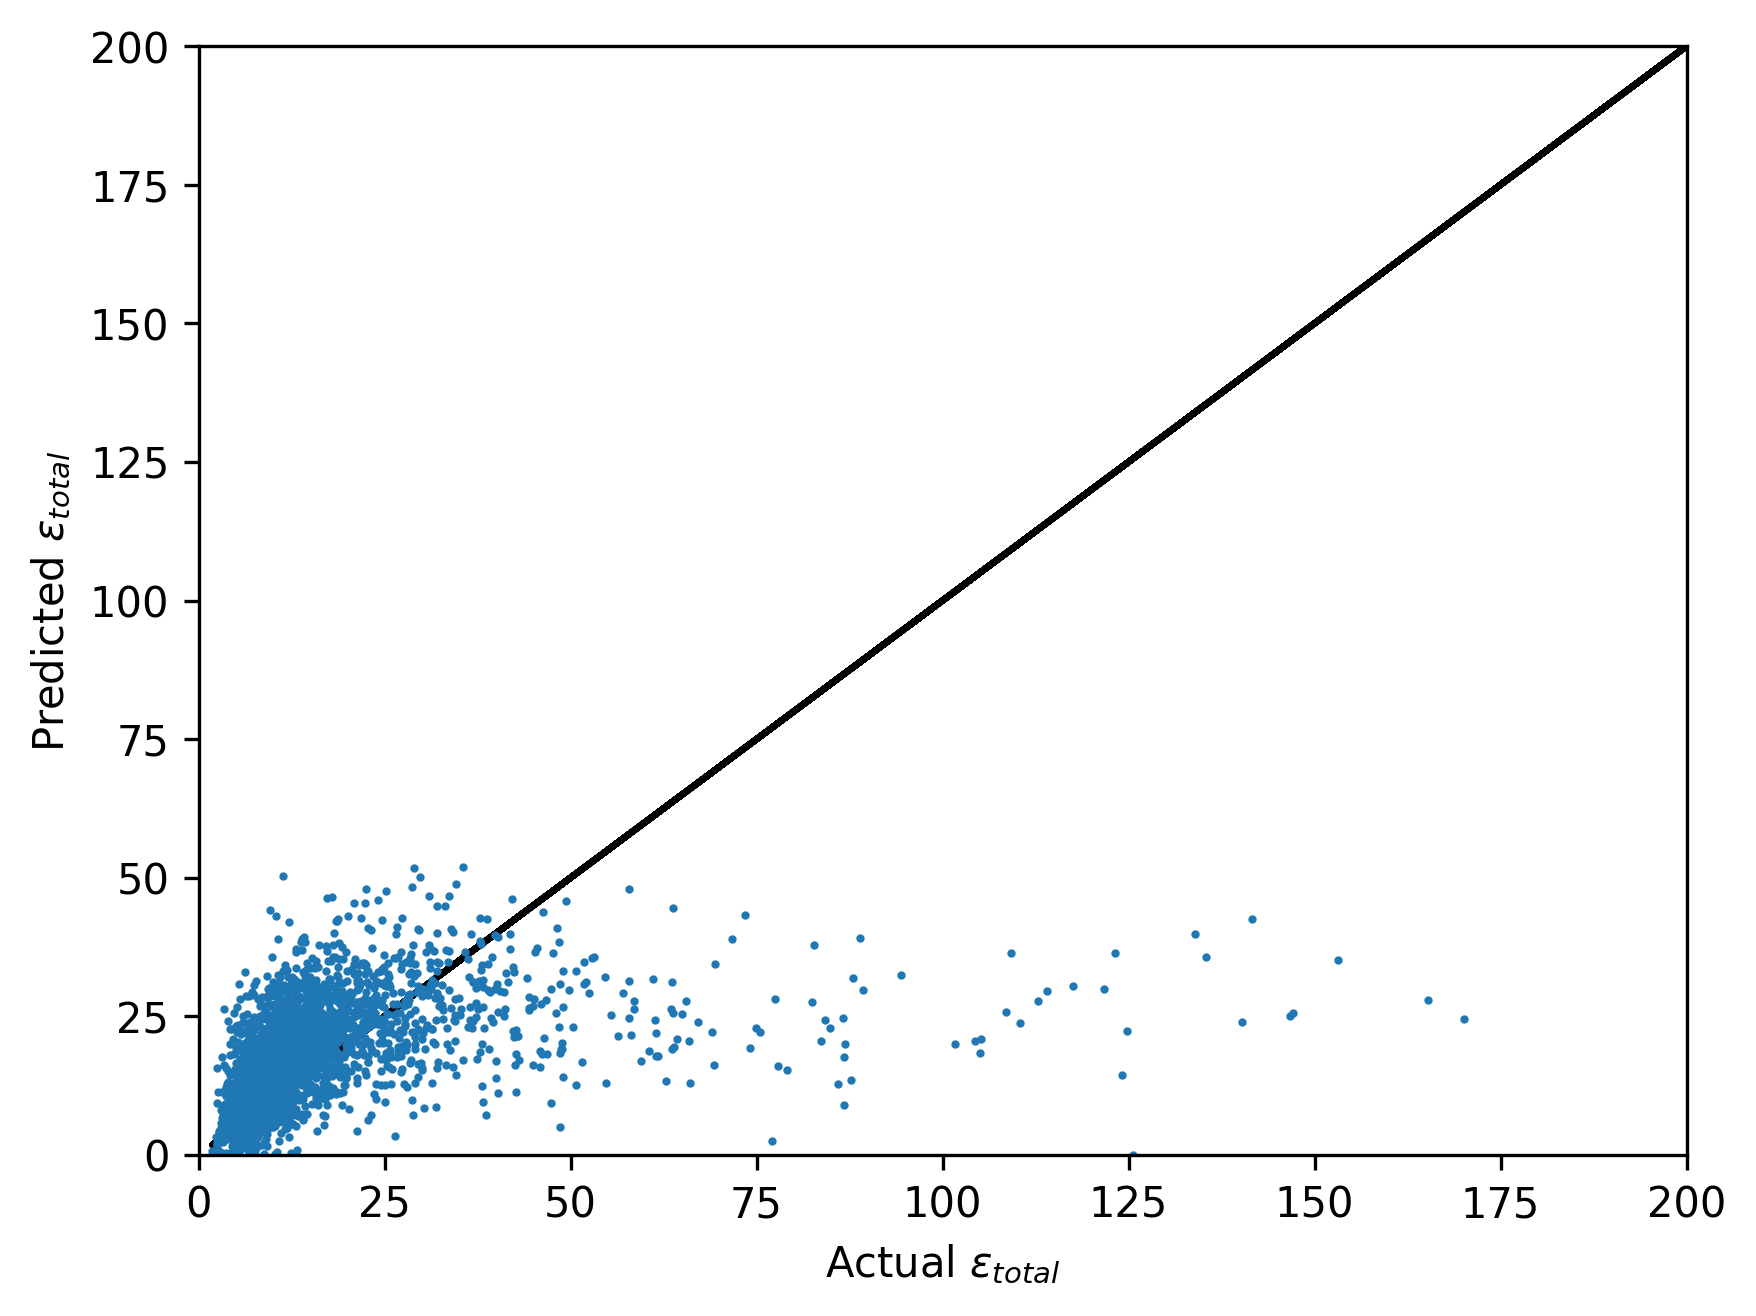

In [11]:
scores, y_hat = model_cross_train(lr, X_4_train, y_4_train)
plot_cross_val_scores(scores.mean(),None, y_hat, y_4_train)

##### 模型学习及测试

MSE: 11751.254433663436, MAE: 26.749494248165558
MSE: 11751.254433663436, MAE: 26.749494248165558


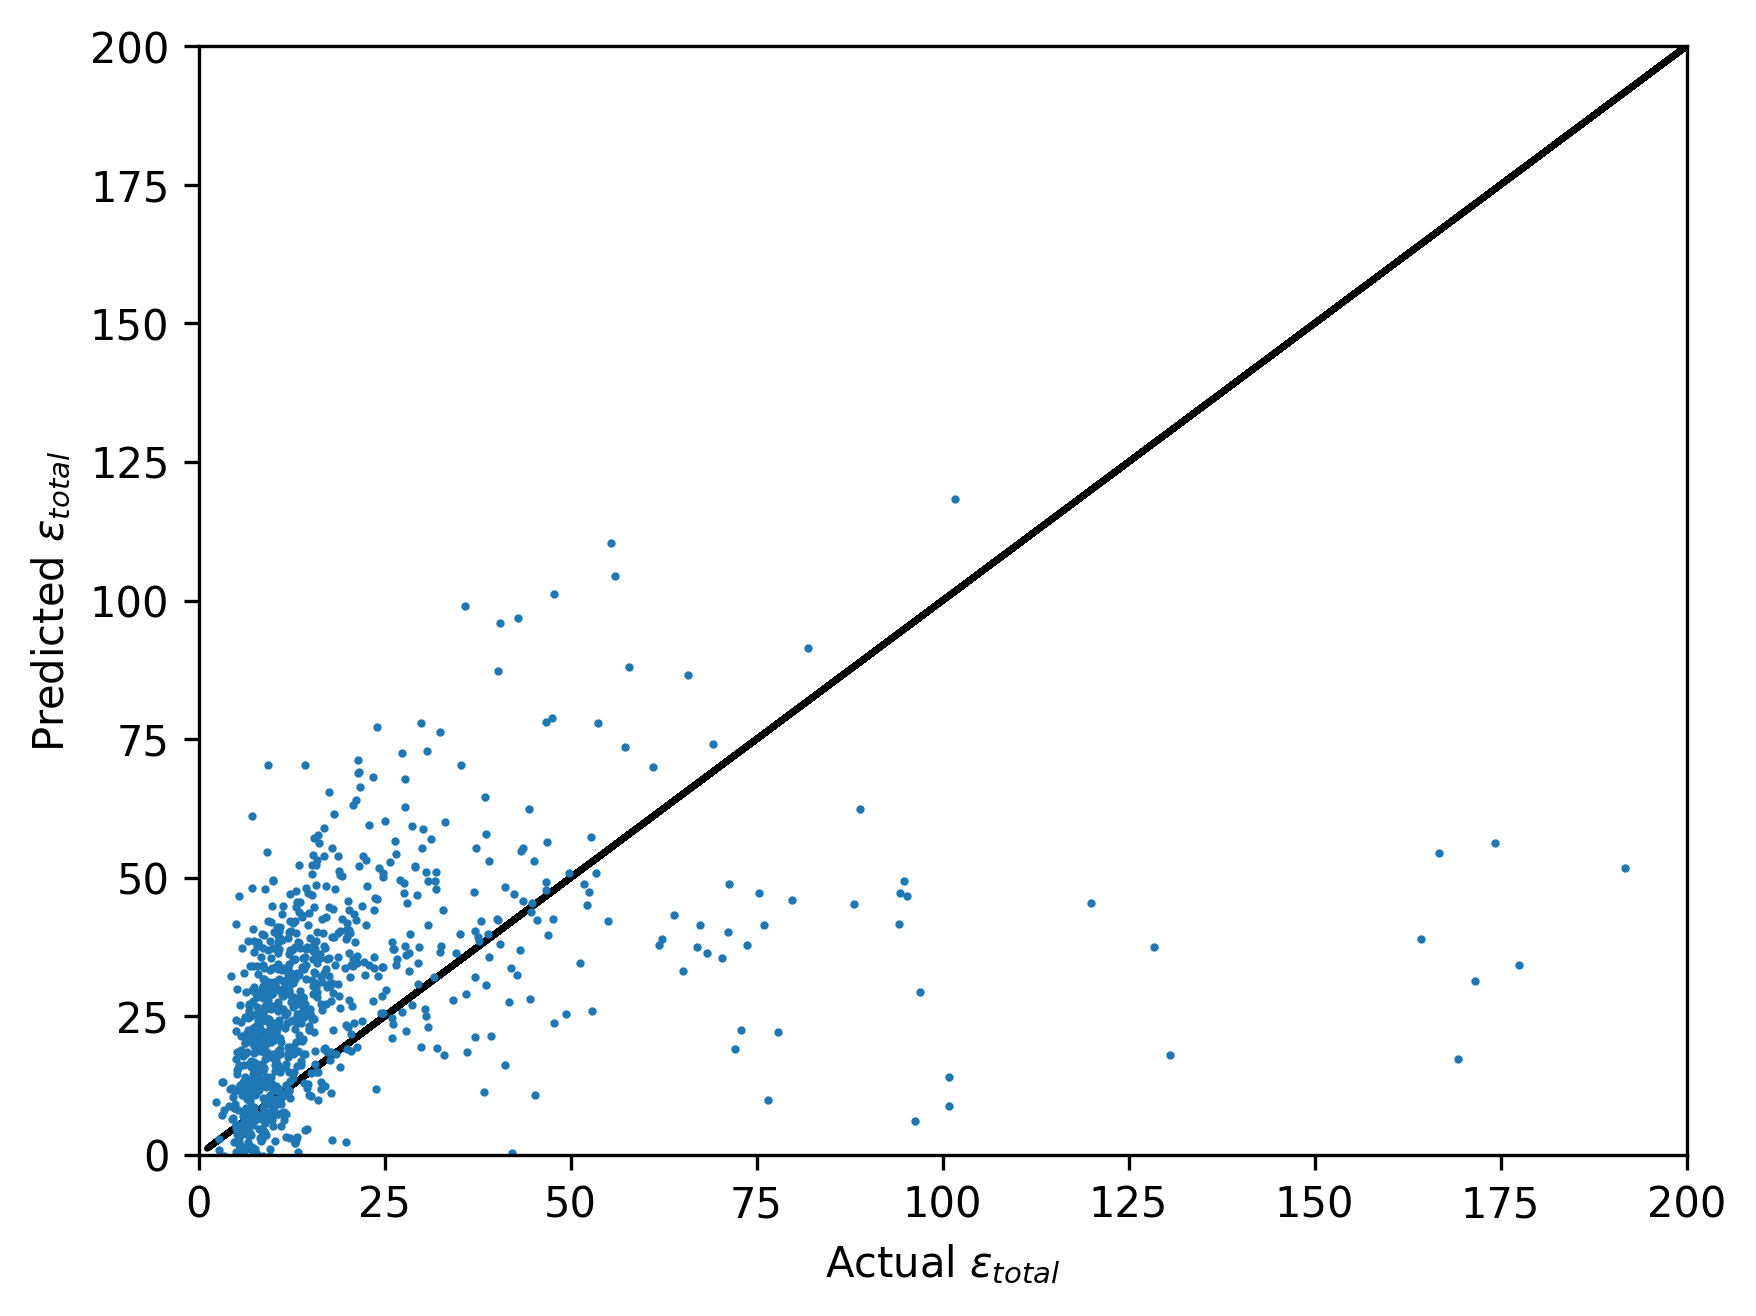

In [12]:
# group0
lr.fit(X_0_train, y_0_train)
mse, mae, y_pred = model_test(lr, X_0_test, y_0_test)
print(f'MSE: {mse}, MAE: {mae}')
plot_cross_val_scores(mse, mae, y_pred, y_0_test)

MSE: 1087.6723148161789, MAE: 10.893026033791594
MSE: 1087.6723148161789, MAE: 10.893026033791594


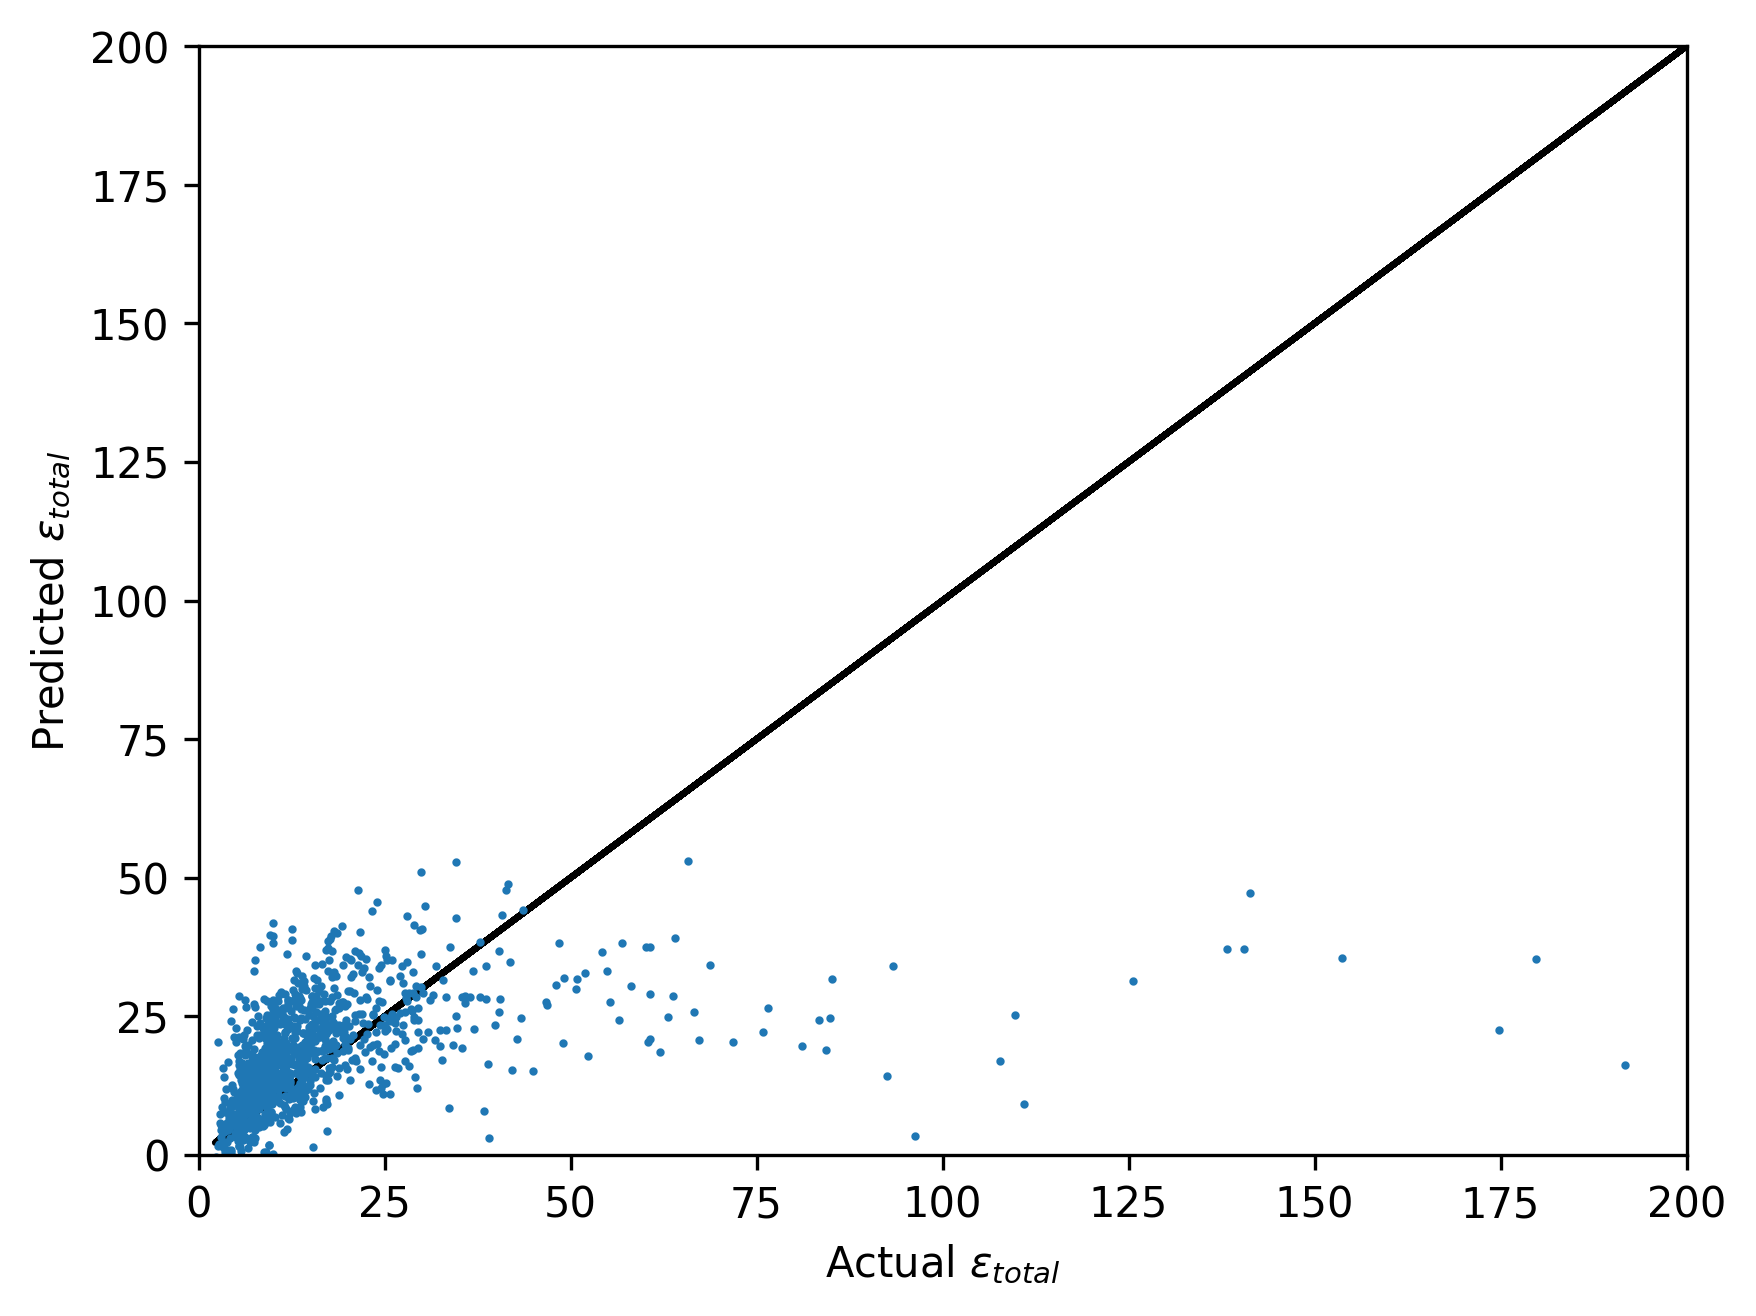

In [13]:
# group4
lr.fit(X_4_train, y_4_train)
mse, mae, y_pred = model_test(lr, X_4_test, y_4_test)
print(f'MSE: {mse}, MAE: {mae}')
plot_cross_val_scores(mse, mae, y_pred, y_4_test)

#### 2. 决策树模型


MSE: -108.25240166849191, MAE: None


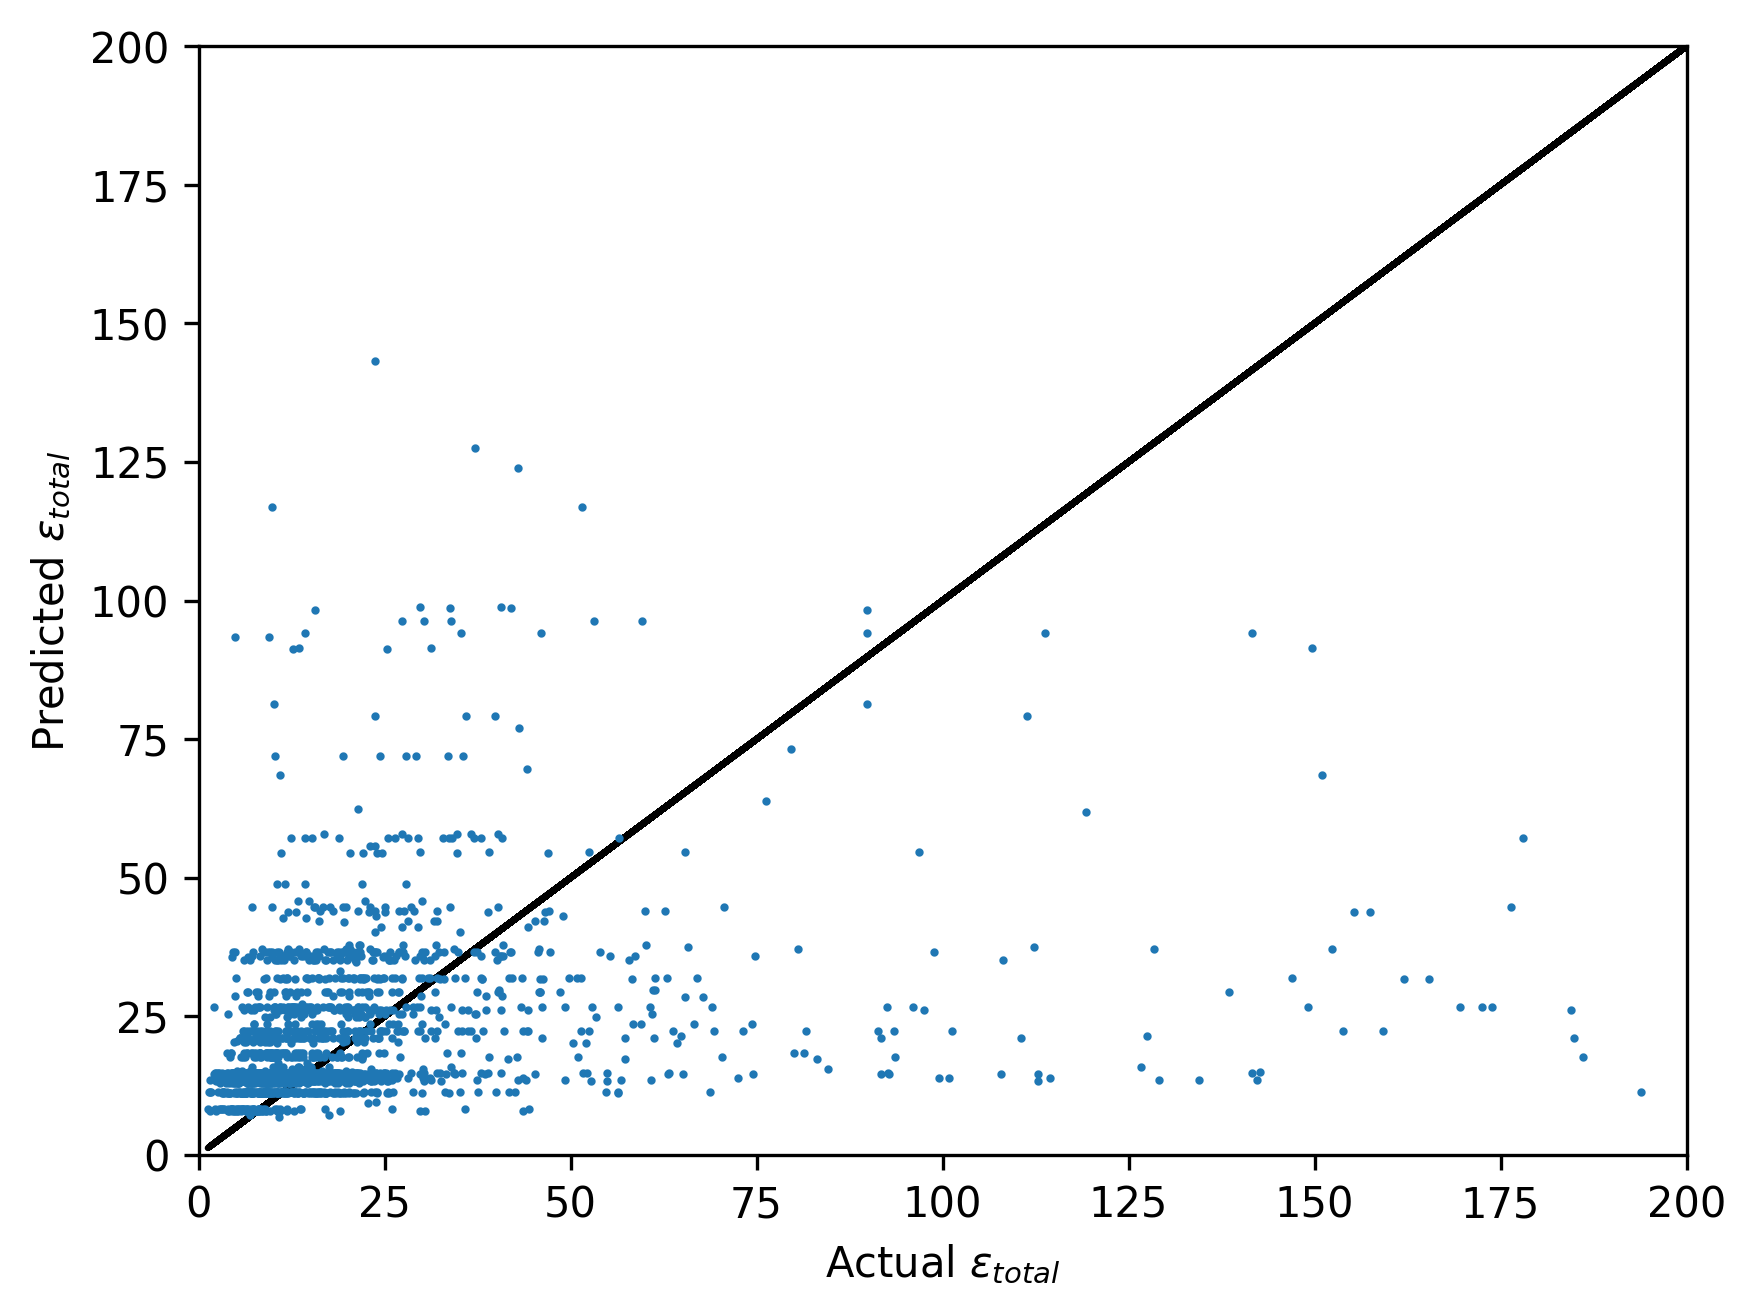

MSE: -101.00368119366082, MAE: None


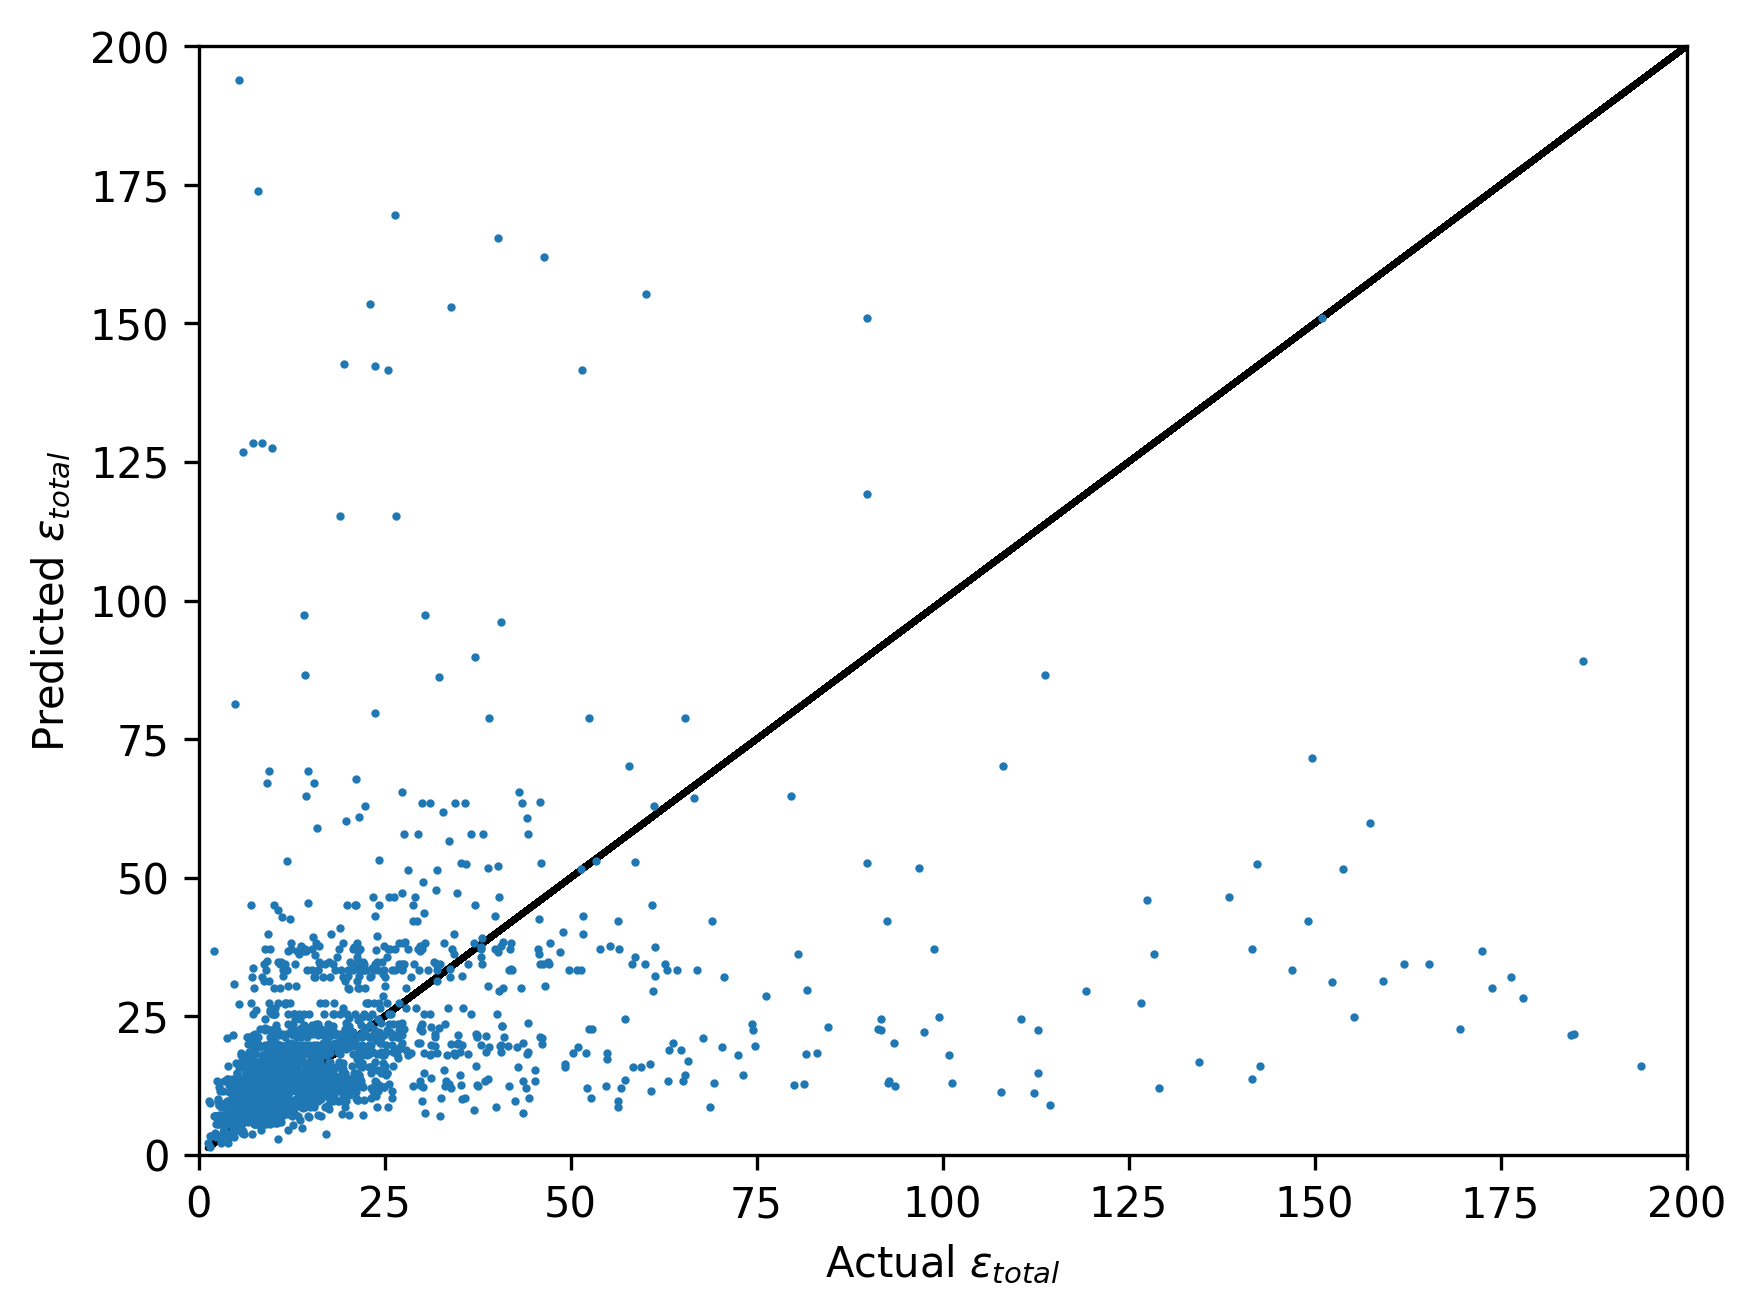

Best depth: 10


In [16]:
from sklearn.tree import DecisionTreeRegressor, plot_tree       # ML model

# group0
# 确定超参数MAX_DEPTH后，使用最优的超参数在整个训练集上训练模型
max_scores=-1e5
BEST_DEPTH_0=0
for depth in range(6, 15):
    dt = DecisionTreeRegressor(max_depth=depth,random_state=RANDOM_STATE)      # decision tree constructor
    scores, y_hat = model_cross_train(dt, X_0_train, y_0_train)                              
    if scores.mean() > max_scores:
        max_scores = scores.mean()
        BEST_DEPTH_0 = depth
        plot_cross_val_scores(scores.mean(), None, y_hat, y_0_train)

print(f'Best depth: {BEST_DEPTH_0}')

MSE: -39.960950557207426, MAE: None


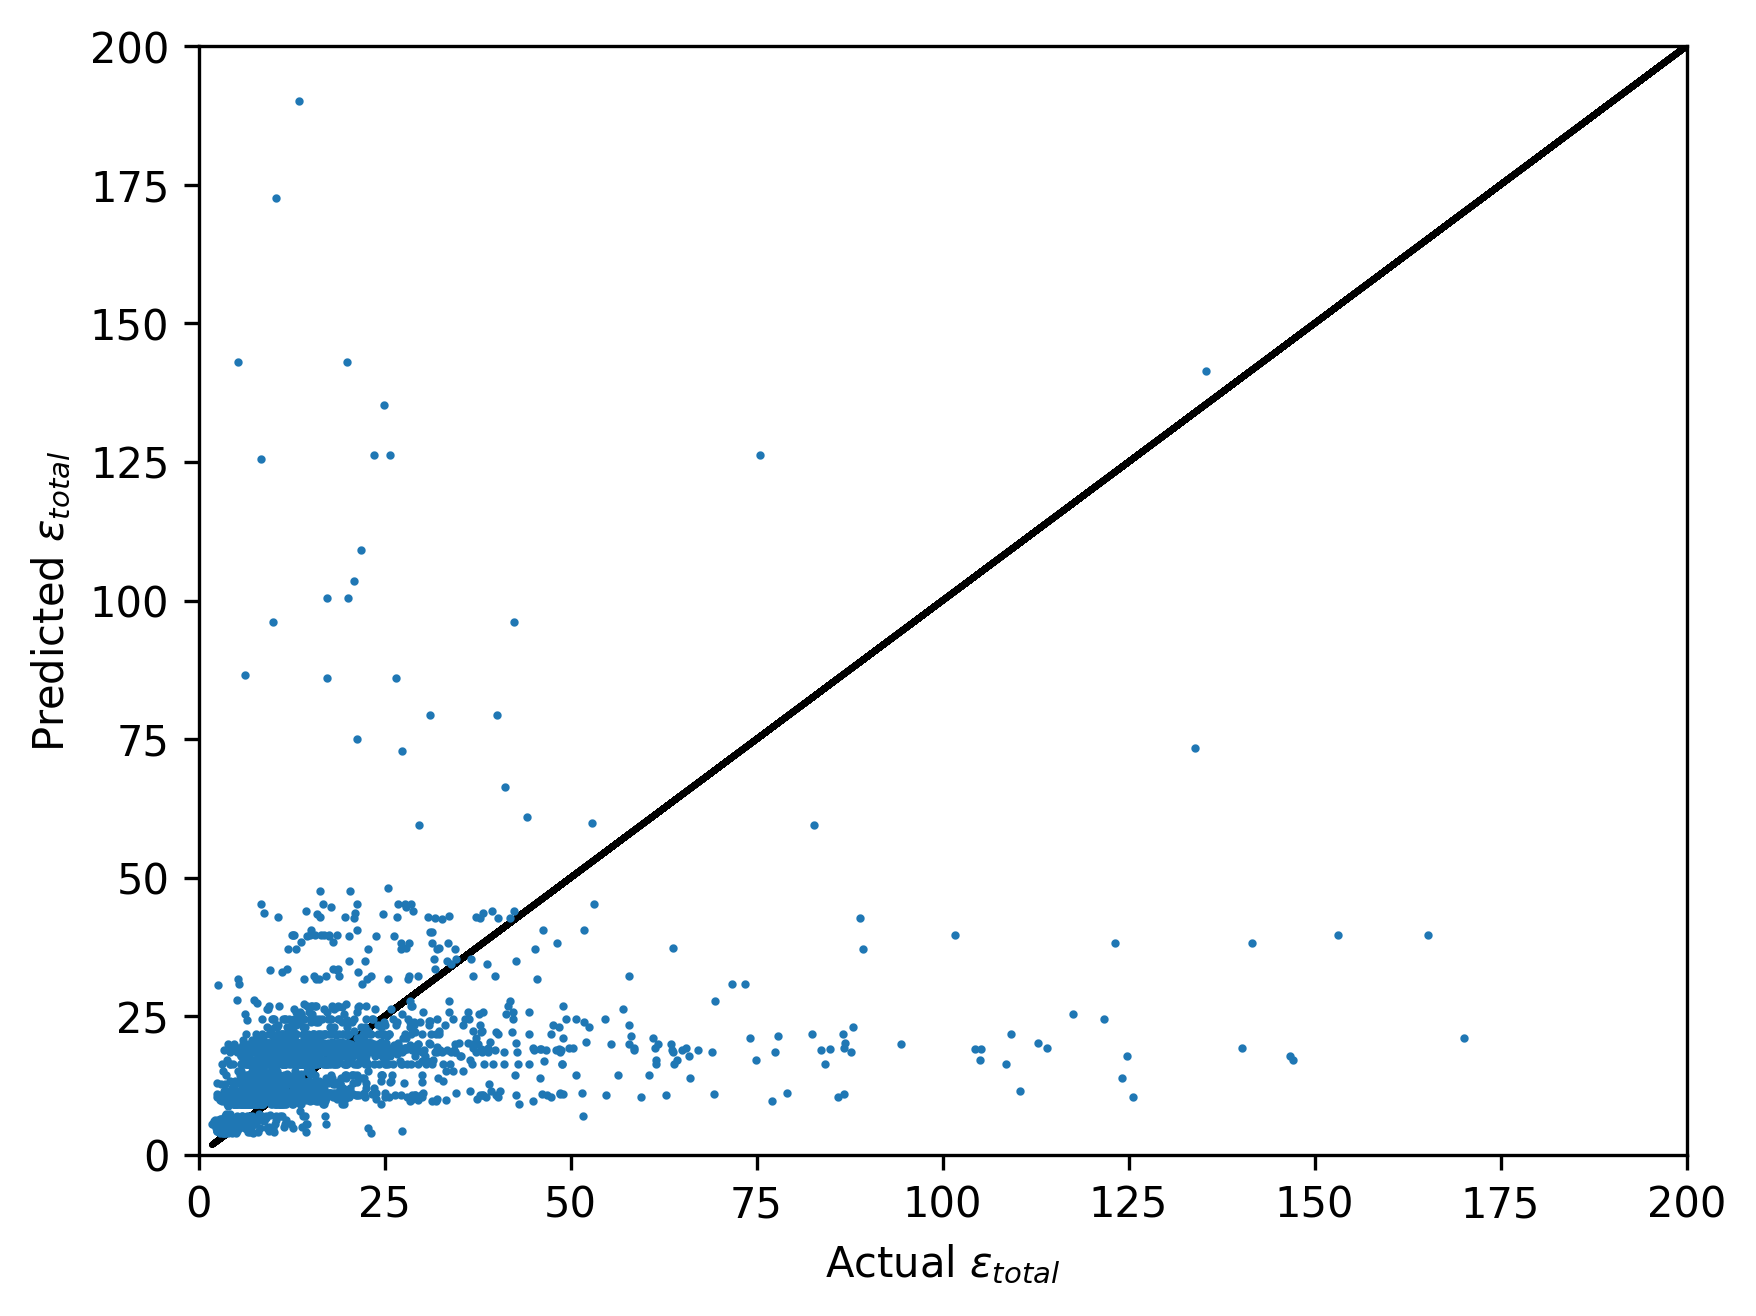

Best depth: 6


In [17]:
# group4
# 确定超参数MAX_DEPTH后，使用最优的超参数在整个训练集上训练模型
max_scores=-1e5
BEST_DEPTH_4=0
for depth in range(6, 15):
    dt = DecisionTreeRegressor(max_depth=depth,random_state=RANDOM_STATE)      # decision tree constructor
    scores, y_hat = model_cross_train(dt, X_4_train, y_4_train)                              
    if scores.mean() > max_scores:
        max_scores = scores.mean()
        BEST_DEPTH_4 = depth
        plot_cross_val_scores(scores.mean(), None, y_hat, y_4_train)

print(f'Best depth: {BEST_DEPTH_4}')

#### 3. 随机森林算法

MSE: -96.69561022526051, MAE: None


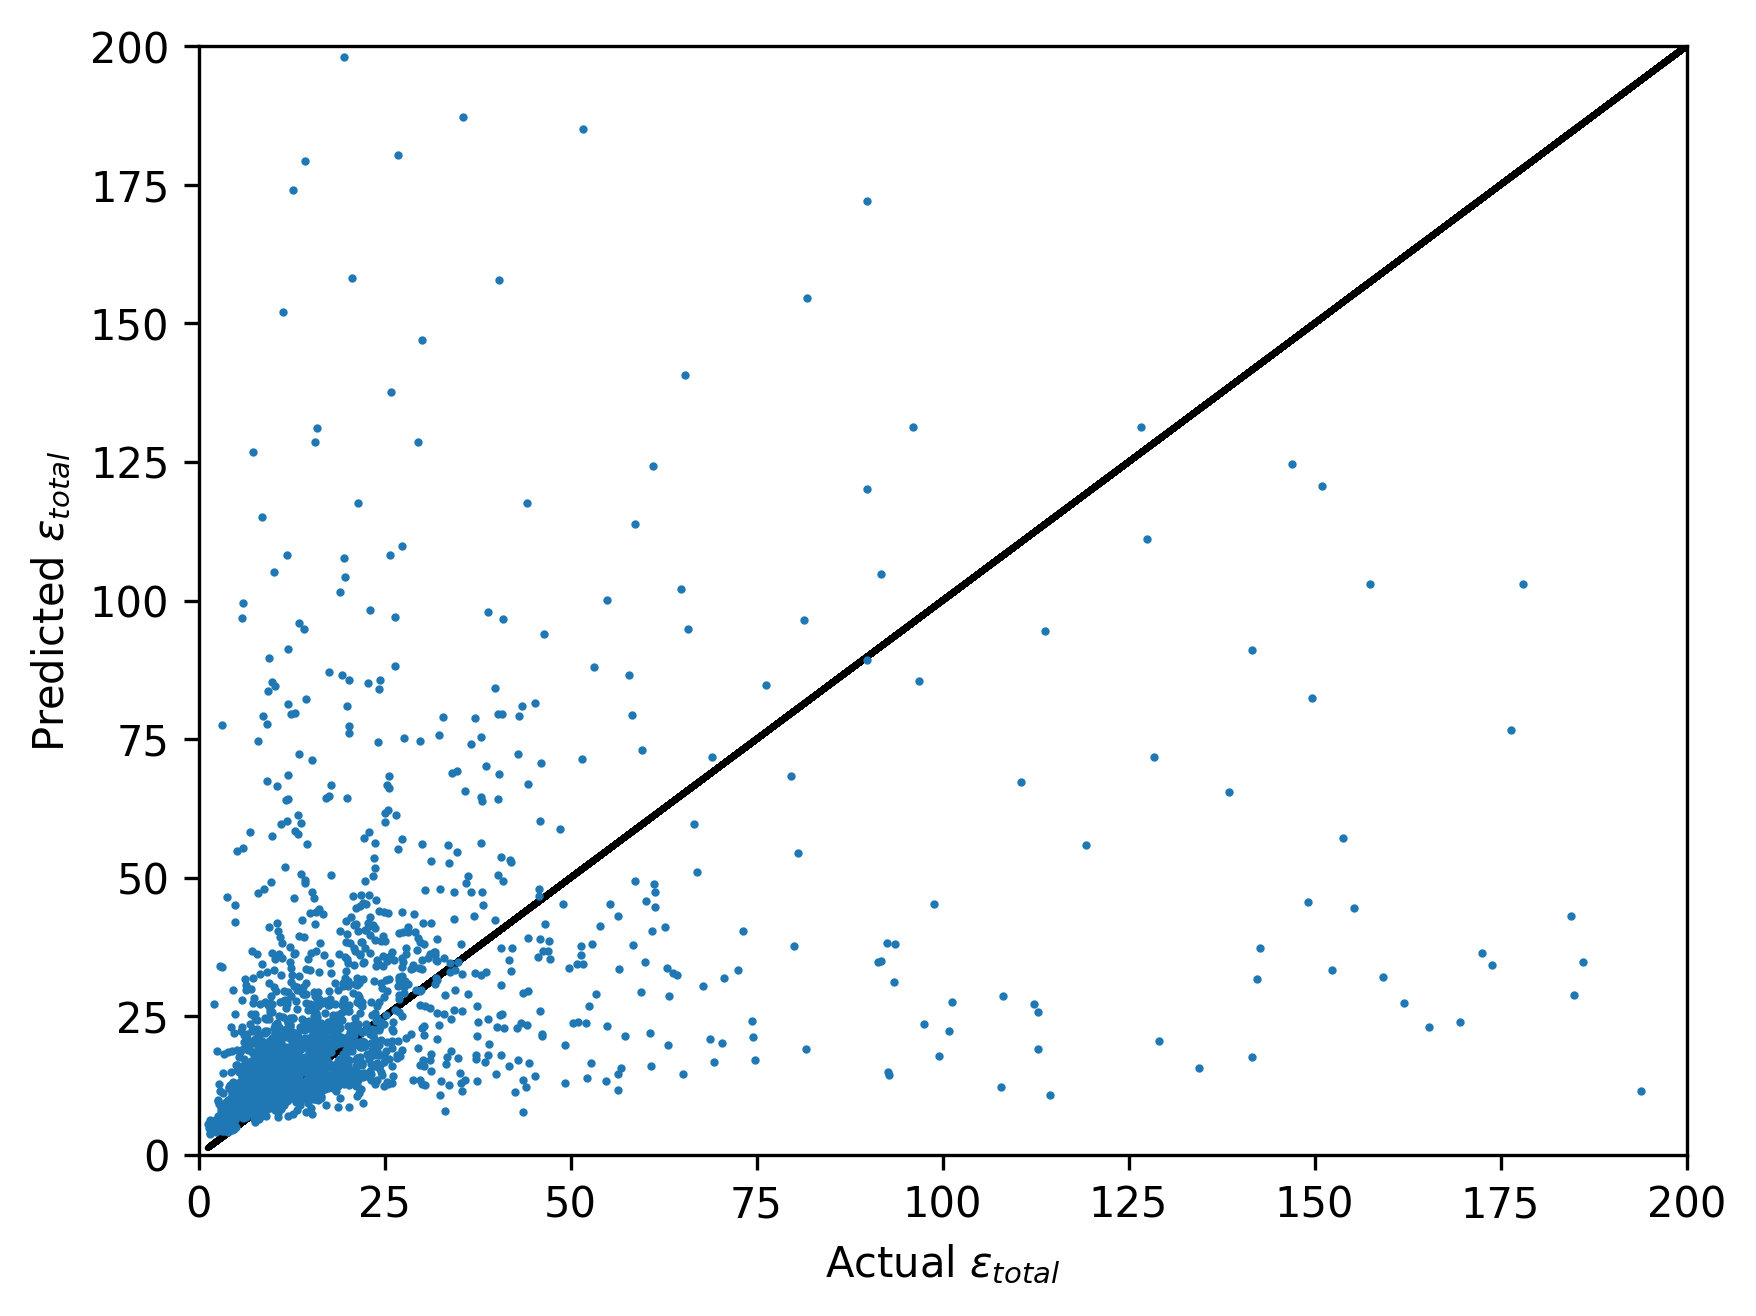

In [19]:
from sklearn.ensemble import RandomForestRegressor
# group0
rf_0 = RandomForestRegressor(n_estimators=100, max_depth=BEST_DEPTH_0, random_state=RANDOM_STATE)
scores, y_hat = model_cross_train(rf_0, X_0_train, y_0_train)
plot_cross_val_scores(scores.mean(), None, y_hat, y_0_train)

MSE: -30.305905625106753, MAE: None


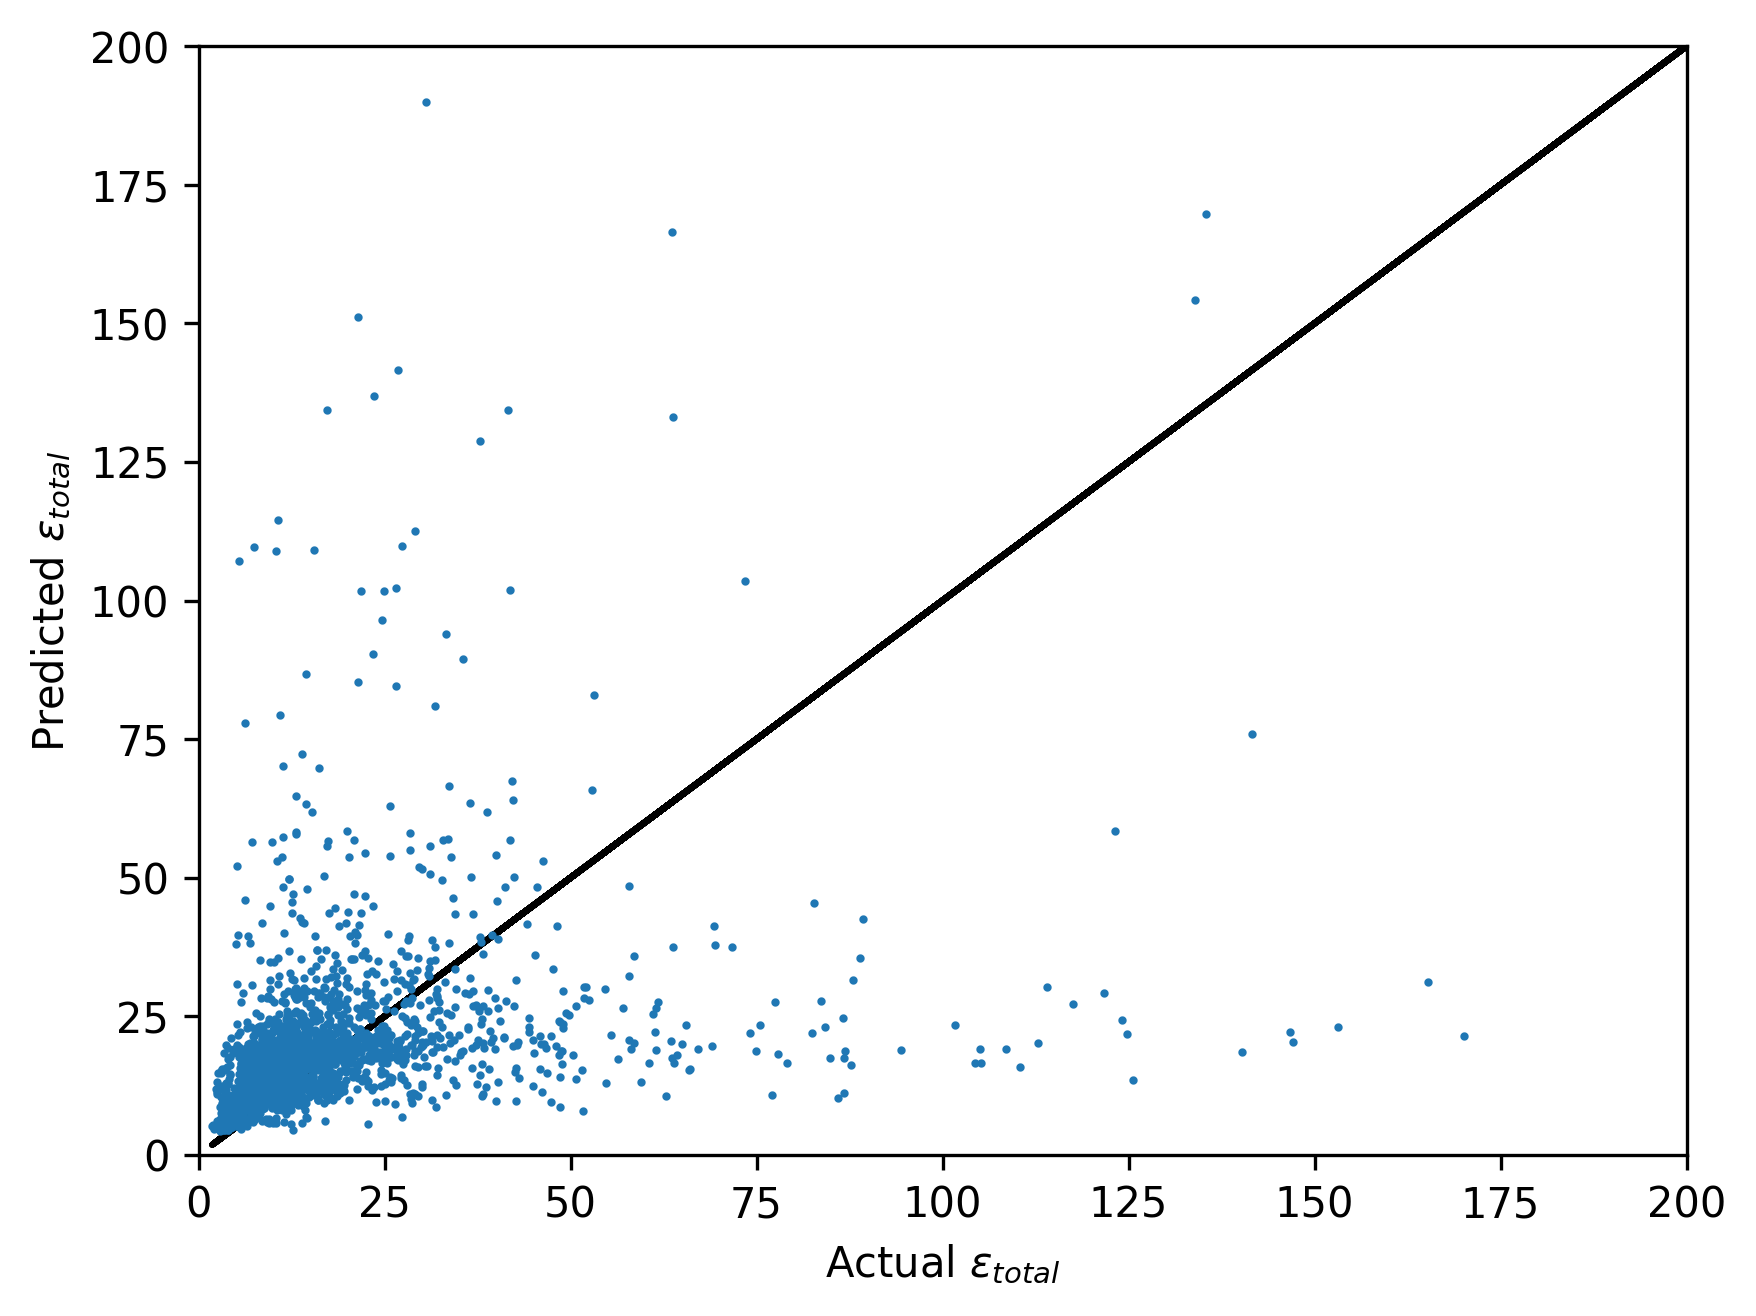

In [20]:
# group4
rf_4 = RandomForestRegressor(n_estimators=100, max_depth=BEST_DEPTH_4, random_state=RANDOM_STATE)
scores, y_hat = model_cross_train(rf_4, X_4_train, y_4_train)
plot_cross_val_scores(scores.mean(), None, y_hat, y_4_train)